<a href="https://colab.research.google.com/github/SkAztecs/Ieee-Task-ML/blob/main/IEEE_CS_ML_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking Data. Not uploading mp4.

In [25]:
!ls -l /content/.kaggle




total 0


In [26]:
!chmod 600 /content/.kaggle/kaggle.json


chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory


In [27]:
!ls -l /content/.kaggle


total 0


In [28]:
!kaggle datasets list


ref                                                   title                                           size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  ----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                              Heart Disease                                   3491  2025-12-11 15:29:14.327000           2114        130  1.0              
wardabilal/spotify-global-music-dataset-20092025      Spotify Global Music Dataset (2009–2025)     1289021  2025-11-11 09:43:05.933000          16387        464  1.0              
neurocipher/student-performance                       Student Performance                            49705  2025-12-12 12:06:28.973000           1261         94  1.0              
suvidyasonawane/student-performance-dataset           Student Performance Dataset                   

In [29]:
!mkdir -p /root/.config/kaggle


In [30]:
!mv /content/.kaggle/kaggle.json /root/.config/kaggle/


mv: cannot stat '/content/.kaggle/kaggle.json': No such file or directory


In [31]:
!chmod 600 /root/.config/kaggle/kaggle.json


In [32]:
!ls -l /root/.config/kaggle


total 4
-rw------- 1 root root 69 Dec 30 13:28 kaggle.json


In [33]:
!kaggle datasets list


ref                                                   title                                           size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  ----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                              Heart Disease                                   3491  2025-12-11 15:29:14.327000           2114        130  1.0              
wardabilal/spotify-global-music-dataset-20092025      Spotify Global Music Dataset (2009–2025)     1289021  2025-11-11 09:43:05.933000          16387        464  1.0              
neurocipher/student-performance                       Student Performance                            49705  2025-12-12 12:06:28.973000           1261         94  1.0              
suvidyasonawane/student-performance-dataset           Student Performance Dataset                   

In [34]:
import cv2

In [35]:
print(cv2.__version__)

4.12.0


In [36]:
import os
import matplotlib.pyplot as plt

In [37]:
fake_path = "train/fake"
print(os.listdir(fake_path)[:5])


['47091d45c0c041e29ac4fcb9b2a674b6.mp4', 'd7d938279e43488cb35d304c1fedf228.mp4', '00469837ba4849189cbf35c65089ee55.mp4', '6b1c9e6e33084e3ea1cc0f37842b9ffd.mp4', '6bd2de8a1b1c4666b506d66865d25317.mp4']


In [38]:
video_path = os.path.join(fake_path, os.listdir(fake_path)[0])
print(video_path)

train/fake/47091d45c0c041e29ac4fcb9b2a674b6.mp4


In [39]:
cap = cv2.VideoCapture(video_path)


In [40]:
ret, frame = cap.read()
print("Read success:", ret)

Read success: True


(np.float64(-0.5), np.float64(853.5), np.float64(479.5), np.float64(-0.5))

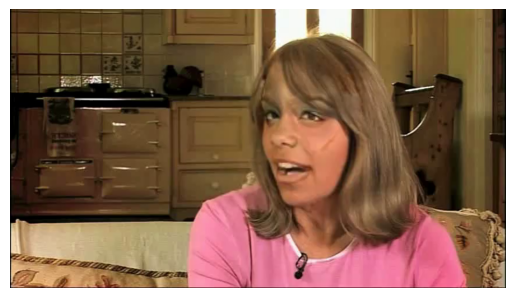

In [41]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.axis("off")

We need this to convert to numericfeatures to progress
so doing this

video.mp4
   ->
sample frames
   ->
resize (224×224)
   ->
CNN feature extractor
   ->
feature vectors
   ->
average
   ->
one vector per video

Load MobileNetV2 to do this

In [42]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg"
)

/tmp/ipython-input-1832084246.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(


In [43]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# resize frame
frame_resized = cv2.resize(frame, (224, 224))

# convert to array
img_array = img_to_array(frame_resized)

# expand dims (batch size = 1)
img_array = np.expand_dims(img_array, axis=0)

# preprocess for MobileNet
img_array = preprocess_input(img_array)


In [44]:
features = model.predict(img_array)
print(features.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1, 1280)


open video
get total_frames
choose frame_indices
for each index:
    seek frame
    read frame
    preprocess
    cnn → feature
average all features
return final vector

In [45]:
NUM_FRAMES = 5
def extract_video_features(video_path, model, num_frames=5):
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    features = []

    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        frame = cv2.resize(frame, (224, 224))
        frame = img_to_array(frame)
        frame = np.expand_dims(frame, axis=0)
        frame = preprocess_input(frame)

        feat = model.predict(frame, verbose=0)
        features.append(feat[0])

    cap.release()

    if len(features) == 0:
        return None

    return np.mean(features, axis=0)

In [47]:
feature_vector = extract_video_features(video_path, model)
print(feature_vector.shape)

(1280,)


In [48]:
X = []
y = []

fake_dir = "train/fake"
real_dir = "train/real"

for fname in os.listdir(fake_dir):
    path = os.path.join(fake_dir, fname)
    feat = extract_video_features(path, model)
    if feat is not None:
        X.append(feat)
        y.append(0)

for fname in os.listdir(real_dir):
    path = os.path.join(real_dir, fname)
    feat = extract_video_features(path, model)
    if feat is not None:
        X.append(feat)
        y.append(1)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (280, 1280)
y shape: (280,)
